We will use a Timer to measure the different parts of the processing

In [1]:
from estimate_phi import Timer

timer = Timer()

We need to read the times from the corresponding file

In [2]:
from read_times import read_times

timer.start()
t1, t2, t3, t4 = read_times('tiempos.txt')
timer.end("Finished reading data ({:.3f}s)")

Finished reading data (7.364s)


We can see that the values are expressed in nanoseconds

In [3]:
print('t1 values:', t1)
print('t2 values:', t2)
print('t3 values:', t3)
print('t4 values:', t4)

# Aclarar que los tiempos están en microsegundos, y cómo te das cuenta con los datos
# Hay que parametrizar la precisión también, porque los datos de NTP están en nanosegundos

t1 values: [1509156751986756 1509156752986747 1509156753986749 ... 1509761549177729
 1509761550177729 1509761551177728]
t2 values: [1509156752018183 1509156753018438 1509156754018521 ... 1509761549888328
 1509761550888102 1509761551888564]
t3 values: [1509156752018194 1509156753018448 1509156754018532 ... 1509761549888343
 1509761550888117 1509761551888580]
t4 values: [1509156751996535 1509156752996693 1509156753996987 ... 1509761549188274
 1509761550188088 1509761551189328]


And we could see that the values are monotonic increasing sequences

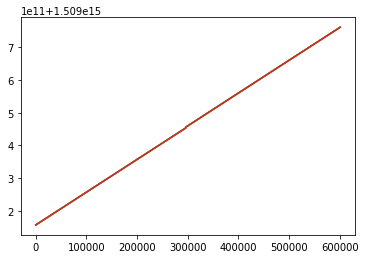

In [4]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(t1)
plt.plot(t2)
plt.plot(t3)
plt.plot(t4)

def is_monotonic_increasing(seq):
    derivate = np.diff(seq)
    less_than_zero = lambda x: x < 0
    negative_values = list(filter(less_than_zero, derivate))
    return len(negative_values) == 0

# esto no es necesariamente cierto
assert is_monotonic_increasing(t1)
assert is_monotonic_increasing(t2)
assert is_monotonic_increasing(t3)

# esto sí
assert is_monotonic_increasing(t4)

Now, we can estimate the phi values using that phi = ((t4 - t1) - (t3 - t2)) / 2

In [5]:
from estimate_phi import phi_estimation

timer.start()
phi_est = phi_estimation(t1, t2, t3, t4)
timer.end("Finished Phi estimation ({:.3f}s)")

Finished Phi estimation (0.017s)


And plot the results

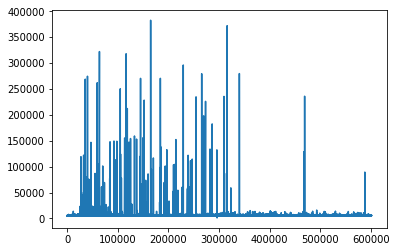

In [6]:
plt.plot(phi_est)

In order to avoid the peaks in the figure, we can smooth the data replacing each point with the median of a window of 600 points

Finished Phi median 600 (5.951s)


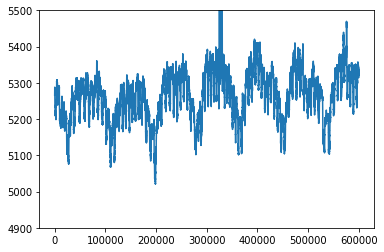

In [21]:
from median_calculator import median_window

timer.start()
phi_med_600 = median_window(phi_est, 600)
timer.end("Finished Phi median 600 ({:.3f}s)")

plt.ylim((4900, 5500))
plt.plot(phi_med_600)

And now we smooth again the data by using a linear regression

Finished Phi lin reg 60 (4.593s)


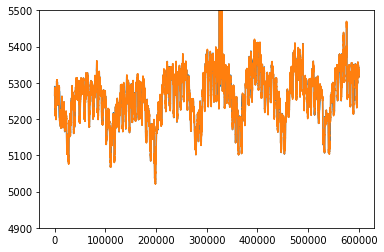

In [23]:
from estimate_phi import linear_reg

t = range(len(phi_med_600))
timer.start()
# Inventar los puntos que no existen (el eje de abscisas no está equiespaciado)
f, k = linear_reg(t, phi_med_600, 60)
phi_lin = np.zeros(60 * (len(t) // 60))
for i in range(len(t) // 60):
    phi_lin[i * 60:(i + 1) * 60] = t[i * 60:(i + 1) * 60] * f[i] + k[i]
timer.end("Finished Phi lin reg 60 ({:.3f}s)")

plt.ylim((4900, 5500))
plt.plot(phi_med_600)

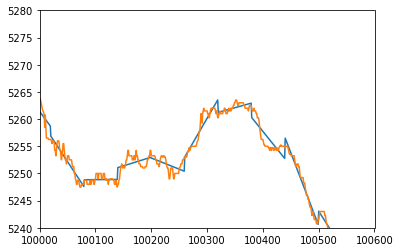

In [33]:
plt.xlim((100000, 100600))
plt.ylim((5240, 5280))
plt.plot(phi_lin)
plt.plot(phi_med_600)
#plt.plot(phi_est)

Now we apply an ARMA filter

Finished Phi ARMA (0.372s)


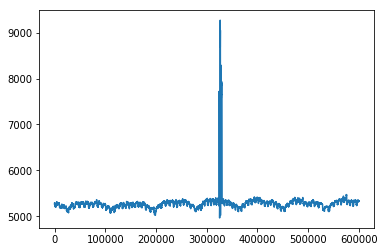

In [44]:
from estimate_phi import arma_filter

timer.start()
alpha = 0.10
f, k = arma_filter(f, k, alpha)
phi_arma = np.zeros(len(phi_lin))
for i in range(len(phi_lin) // 60):
    phi_arma[i * 60:(i + 1) * 60] = t[i * 60:(i + 1) * 60] * f[i] + k[i]
timer.end("Finished Phi ARMA ({:.3f}s)")

plt.plot(phi_arma)

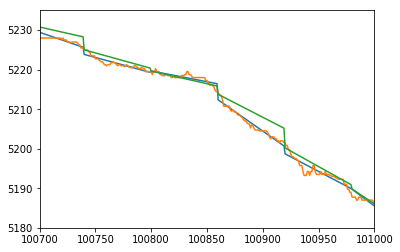

In [45]:
plt.xlim((100700, 101000))
plt.ylim((5180, 5235))
plt.plot(phi_lin)
plt.plot(phi_med_600)
plt.plot(phi_arma)
#buscar algun lugar donde se note la diferencia entre linear y arma

By last, we save the data in a file to see it later

In [10]:
np.savetxt('phi_arma.txt', phi_arma)